In [1]:
# @title Setup and Install Dependencies
# 必要なライブラリをインストールします
!pip install -q transformers torch scikit-learn matplotlib seaborn

print("Setup complete.")

Setup complete.


In [2]:
# @title DFS Layer Visualizer Code
# コアロジックと可視化関数の定義

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

class DFSLayerAnalyzer:
    """
    LLMのData Flow Space (DFS) における層間の類似度を分析するクラス
    """
    def __init__(self, model_name: str, device: str = None):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading model: {model_name} on {self.device}...")

        # モデルとトークナイザーの読み込み
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # hidden_statesを出力するように設定
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(self.device)
        self.model.eval()

    def compute_layer_similarity(self, text: str) -> np.ndarray:
        """
        入力テキストに基づいて、全層間のコサイン類似度行列を計算する
        """
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)

        # hidden_states: (Embeddings + 各層の出力) のタプル
        hidden_states = outputs.hidden_states

        # 各層のベクトルを抽出
        # ここでは簡易的に「最後のトークン」のベクトルをその層の代表値とします
        # shape: (num_layers + 1, hidden_dim)
        layer_vectors = []
        for h in hidden_states:
            # hの形状: (batch, seq_len, hidden_dim) -> (1, seq, dim)
            # 最後のトークンを取得: h[0, -1, :]
            vec = h[0, -1, :].cpu().numpy()
            layer_vectors.append(vec)

        layer_vectors = np.array(layer_vectors)

        # コサイン類似度の計算
        # 結果は (num_layers + 1) x (num_layers + 1) の行列
        sim_matrix = cosine_similarity(layer_vectors)

        return sim_matrix

def plot_dfs_heatmap(matrix: np.ndarray, model_name: str):
    """
    類似度行列をヒートマップとして描画する
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matrix,
        annot=False,
        cmap="viridis", # 研究っぽいカラーマップ
        square=True,
        cbar_kws={'label': 'Cosine Similarity'}
    )

    plt.title(f"Data Flow Space Similarity: {model_name}\n(Layer Representations)", fontsize=14)
    plt.xlabel("Target Layer Index", fontsize=12)
    plt.ylabel("Source Layer Index", fontsize=12)

    # 軸の目盛り調整（5層ごと）
    step = 5
    ticks = np.arange(0, matrix.shape[0], step)
    plt.xticks(ticks + 0.5, ticks)
    plt.yticks(ticks + 0.5, ticks, rotation=0)

    plt.tight_layout()
    plt.show()

print("Functions defined.")

Functions defined.


Loading model: gpt2 on cpu...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]


Analyzed 13 layers (including embeddings).
Generating Heatmap...


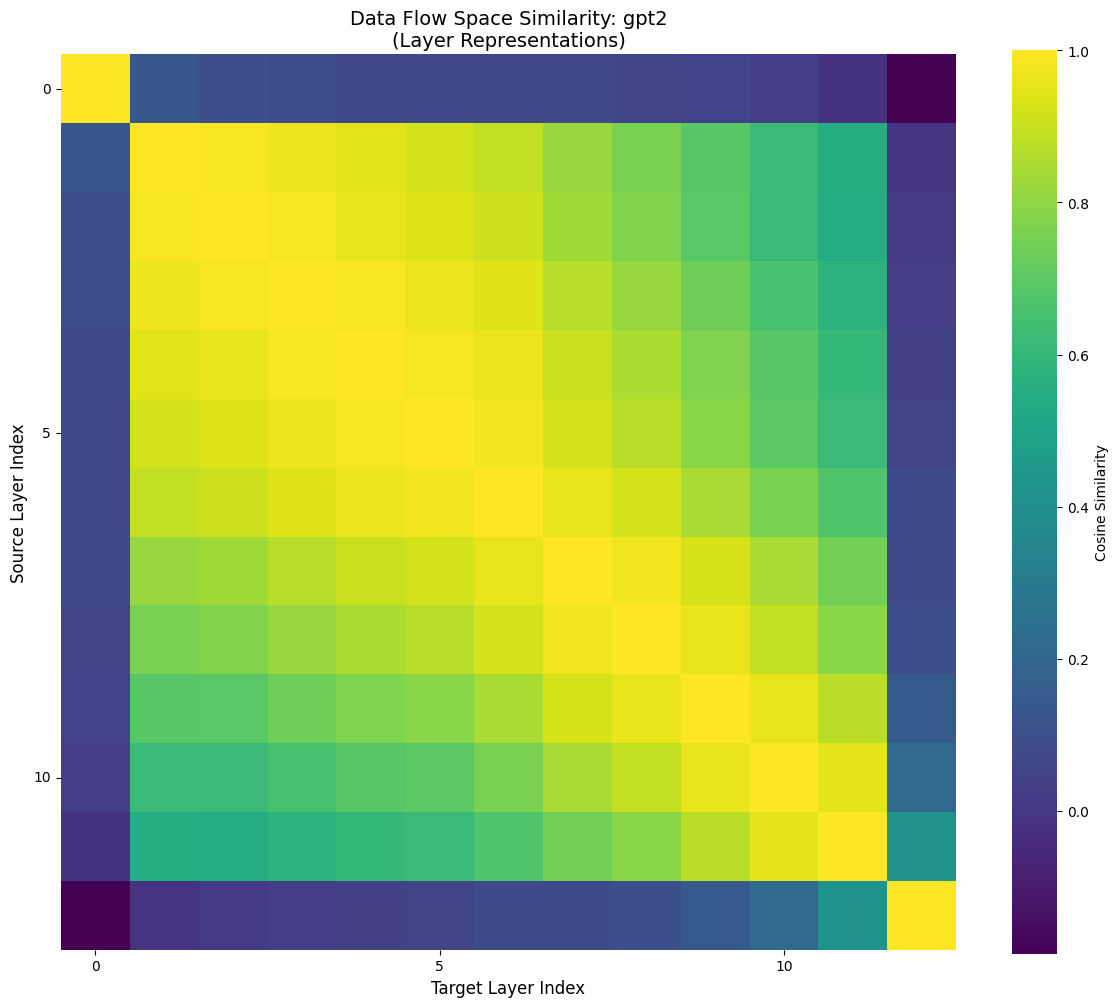

In [3]:
# @title Execute Analysis
# 実際にモデルを動かして可視化を実行します

# --- 設定 ---
# デモ用に軽量なGPT-2を使用（Llama-2/3なども指定可能ですがHuggingFaceの認証が必要です）
MODEL_NAME = "gpt2"
SAMPLE_TEXT = "Model merging is a technique to combine multiple LLMs into a single model."

# --- 実行 ---
analyzer = DFSLayerAnalyzer(MODEL_NAME)
similarity_matrix = analyzer.compute_layer_similarity(SAMPLE_TEXT)

print(f"\nAnalyzed {similarity_matrix.shape[0]} layers (including embeddings).")
print("Generating Heatmap...")

plot_dfs_heatmap(similarity_matrix, MODEL_NAME)